# Classify structured data using TensorFlow

This tutorial demonstrates how to classify structured data, such as tabular data, using a simplified version of the <a href="https://www.kaggle.com/c/petfinder-adoption-prediction" class="external">PetFinder dataset from a Kaggle competition</a> stored in a CSV file.

You will use keras to define the model and to train the model. The goal is to predict if a pet will be adopted.


## The PetFinder.my mini dataset

There are several thousand rows in the PetFinder.my mini's CSV dataset file, where each row describes a pet (a dog or a cat) and each column describes an attribute, such as age, breed, color, and so on.

In the dataset's summary below, notice there are mostly numerical and categorical columns. In this tutorial, you will only be dealing with those two feature types, dropping `Description` (a free text feature) and `AdoptionSpeed` (a classification feature) during data preprocessing.

| Column          | Pet description               | Feature type   | Data type |
| --------------- | ----------------------------- | -------------- | --------- |
| `Type`          | Type of animal (`Dog`, `Cat`) | Categorical    | String    |
| `Age`           | Age                           | Numerical      | Integer   |
| `Breed1`        | Primary breed                 | Categorical    | String    |
| `Color1`        | Color 1                       | Categorical    | String    |
| `Color2`        | Color 2                       | Categorical    | String    |
| `MaturitySize`  | Size at maturity              | Categorical    | String    |
| `FurLength`     | Fur length                    | Categorical    | String    |
| `Vaccinated`    | Pet has been vaccinated       | Categorical    | String    |
| `Sterilized`    | Pet has been sterilized       | Categorical    | String    |
| `Health`        | Health condition              | Categorical    | String    |
| `Fee`           | Adoption fee                  | Numerical      | Integer   |
| `Description`   | Profile write-up              | Text           | String    |
| `PhotoAmt`      | Total uploaded photos         | Numerical      | Integer   |
| `AdoptionSpeed` | Categorical speed of adoption | Classification | Integer   |

## Import TensorFlow and other libraries


In [53]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt

SEED = 12
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Load the dataset and read it into a pandas DataFrame

Use `tf.keras.utils.get_file` to download and extract the CSV file with the PetFinder.my mini dataset, and load it into a dataframe.


In [26]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
data = pd.read_csv(csv_file)

Inspect the dataset by checking the first five rows of the DataFrame:

In [27]:
data.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


## Create a target variable

`AdoptionSpeed` column contains the speed at which a pet will be adopted.


| Column            | Description               |
| ----------------- | ----------------------------- | 
| 0     | Pet was adopted on the same day as it was listed.                            |
| 1     | Pet was adopted between 1 and 7 days (1st week) after being listed.          |
| 2     | Pet was adopted between 8 and 30 days (1st month) after being listed.        |
| 3     | Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed. |
| 4     | No adoption after 100 days of being listed.                                  |

In this tutorial, you will have to predict whether a pet was adopted or not.


---

***Task: 1***

Create a new column called `target` which contains 
`0` when the pet was not adopted, and `1` if it was.

Drop the columns `AdoptionSpeed` and `Description`.

---

In [28]:
data['target'] = np.where(data['AdoptionSpeed']==4, 0, 1)

# Drop unused features.
data = data.drop(columns=['AdoptionSpeed', 'Description'])

## Inspecting the data closer

In [29]:
numeric_columns = ['Age', 'Fee', 'PhotoAmt']
categoric_columns = ['Type', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize',
       'FurLength', 'Vaccinated', 'Sterilized', 'Health']

In [30]:
for cat_cols in categoric_columns:
  print(data[cat_cols].value_counts())
  print("--------------------------------")

Dog    6601
Cat    4936
Name: Type, dtype: int64
--------------------------------
Mixed Breed             4629
Domestic Short Hair     2605
Domestic Medium Hair     865
Tabby                    242
Domestic Long Hair       223
                        ... 
Bedlington Terrier         1
American Bulldog           1
Rhodesian Ridgeback        1
Setter                     1
Dutch Shepherd             1
Name: Breed1, Length: 166, dtype: int64
--------------------------------
Female    6466
Male      5071
Name: Gender, dtype: int64
--------------------------------
Black     5241
Brown     3075
Golden     789
Cream      765
White      593
Gray       575
Yellow     499
Name: Color1, dtype: int64
--------------------------------
No Color    3968
White       2920
Brown       2203
Cream        788
Gray         659
Yellow       535
Golden       464
Name: Color2, dtype: int64
--------------------------------
Medium    8016
Small     2480
Large     1041
Name: MaturitySize, dtype: int64
--------------

---

***Task: 2***

Since the `Breed1` column has 166 different types, replace the less frequent breeds (occuring less than 100 times) with category `Rare`.

---

In [31]:
freq_breeds = data['Breed1'].value_counts()[data['Breed1'].value_counts() > 100].index.to_list()
data['Breed1'] = data['Breed1'].apply(lambda x: 'Rare' if x not in freq_breeds else x)

data['Breed1'].value_counts()

Mixed Breed             4629
Domestic Short Hair     2605
Rare                    1804
Domestic Medium Hair     865
Tabby                    242
Domestic Long Hair       223
Siamese                  202
Shih Tzu                 178
Persian                  177
Labrador Retriever       175
Poodle                   161
Terrier                  143
Golden Retriever         133
Name: Breed1, dtype: int64

## Categorical columns

In [32]:
data.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,1


---

***Task: 3***

For each categoric feature in the dataset, convert it to one-hot encoded feature. The new column names should be in readable format like `is_Type_Cat`, `is_Type_Dog`, etc.

---

In [33]:
for cat_col in categoric_columns:
  data = pd.get_dummies(data, columns=[cat_col], prefix=f"is_{cat_col}")
data.head()

,Age,Fee,PhotoAmt,target,is_Type_Cat,is_Type_Dog,is_Breed1_Domestic Long Hair,is_Breed1_Domestic Medium Hair,is_Breed1_Domestic Short Hair,is_Breed1_Golden Retriever,...,is_FurLength_Short,is_Vaccinated_No,is_Vaccinated_Not Sure,is_Vaccinated_Yes,is_Sterilized_No,is_Sterilized_Not Sure,is_Sterilized_Yes,is_Health_Healthy,is_Health_Minor Injury,is_Health_Serious Injury
0,3,100,1,1,1,0,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0
1,1,0,2,1,1,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0
2,1,0,7,1,0,1,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
3,4,150,8,1,0,1,0,0,0,0,...,1,0,0,1,1,0,0,1,0,0
4,1,0,3,1,0,1,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0


## Split the DataFrame into training, validation, and test sets

The dataset is in a single pandas DataFrame. Split it into training, validation, and test respectively:

---

***Task: 4***
Split the data sets in 80:10:10 ratio.

---

In [34]:
from sklearn.model_selection import train_test_split

train, val_test = train_test_split(data, test_size=0.2)
val, test = train_test_split(val_test, test_size=0.5)

del val_test

In [35]:
print(f'Training examples: {len(train)}')
print(f'Validation examples: {len(val)}')
print(f'Test examples: {len(test)}')

Training examples: 9229
Validation examples: 1154
Test examples: 1154


## Numerical columns

For each numeric feature in the dataset, standardize the distribution of the data.

---

***Task: 5***

Complete the `get_normalized_data` function by normalizing the columns given in the list `column_names`.

---

In [36]:
def get_normalized_data(df, column_names):
  for col_name in column_names:
    mean = df[col_name].mean()
    std = df[col_name].std()
    df[col_name] = (df[col_name] - mean)/ std

  return df

In [37]:
train = get_normalized_data(train, ['Age', 'Fee', 'PhotoAmt'])
val = get_normalized_data(val, ['Age', 'Fee', 'PhotoAmt'])
test = get_normalized_data(test, ['Age', 'Fee', 'PhotoAmt'])

Get the features and targets

In [38]:
y_train = train.pop('target')
X_train = train

y_val = val.pop('target')
X_val = val

y_test = test.pop('target')
X_test = test



In [41]:
print(f"Feature shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")

Feature shape: (9229, 49)
Target shape: (9229,)


## Create, compile, and train the model


The next step is to create a model using the sequential and configure the model with Keras `Model.compile`.

---

***Task: 6***

Complete the `create_model` function by building and compiling the model. Use 2 dense hidden layers and a dropout layer. Also choose an appropriate optimizer and loss function, and configure the model to log accuracy as a metric.

---

In [66]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1])),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(1)
  ])
  model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

model = create_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               6400      
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 23,041
Trainable params: 23,041
Non-trainable params: 0
_________________________________________________________________


Next, train and test the model:

In [49]:
NUM_EPOCHS = 5

training_info = model.fit(x=X_train, y=y_train, epochs=NUM_EPOCHS, validation_data=(X_val, y_val))

Epoch 1/10
289/289 [==============================] - 1s 3ms/step - loss: 0.5348 - accuracy: 0.7260 - val_loss: 0.5350 - val_accuracy: 0.7253
Epoch 2/10
289/289 [==============================] - 1s 3ms/step - loss: 0.5074 - accuracy: 0.7433 - val_loss: 0.5322 - val_accuracy: 0.7036
Epoch 3/10
289/289 [==============================] - 1s 2ms/step - loss: 0.4957 - accuracy: 0.7484 - val_loss: 0.5167 - val_accuracy: 0.7270
Epoch 4/10
289/289 [==============================] - 1s 2ms/step - loss: 0.4851 - accuracy: 0.7538 - val_loss: 0.5218 - val_accuracy: 0.7140
Epoch 5/10
289/289 [==============================] - 1s 2ms/step - loss: 0.4804 - accuracy: 0.7608 - val_loss: 0.5317 - val_accuracy: 0.7166
Epoch 6/10
289/289 [==============================] - 1s 2ms/step - loss: 0.4749 - accuracy: 0.7621 - val_loss: 0.5244 - val_accuracy: 0.7374
Epoch 7/10
289/289 [==============================] - 1s 2ms/step - loss: 0.4661 - accuracy: 0.7674 - val_loss: 0.5232 - val_accuracy: 0.7244
Epoch 

In [56]:
loss_history = training_info.history['loss']
accuracy_history = training_info.history['accuracy']

val_loss_history = training_info.history['val_loss']
val_accuracy_history = training_info.history['val_accuracy']

---

***Task: 7***

Plot the loss and accuracy curves for both training and validation in 2 subplots.

---

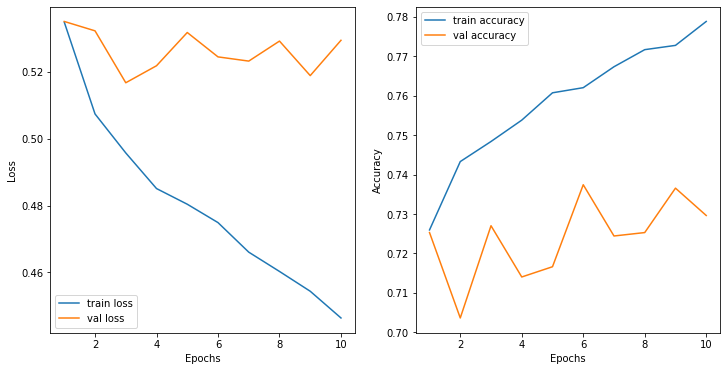

In [61]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axs[0].plot(range(1, NUM_EPOCHS+1), loss_history, label="train loss")
axs[0].plot(range(1, NUM_EPOCHS+1), val_loss_history, label="val loss")
axs[0].legend()
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")

axs[1].plot(range(1, NUM_EPOCHS+1), accuracy_history, label="train accuracy")
axs[1].plot(range(1, NUM_EPOCHS+1), val_accuracy_history, label="val accuracy")
axs[1].legend()
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

plt.show()

In [62]:
loss, accuracy = model.evaluate(x=X_test, y=y_test)
print("Accuracy", accuracy)

37/37 [==============================] - 0s 2ms/step - loss: 0.5025 - accuracy: 0.7331
Accuracy 0.7331022620201111


---

***Task: 8***

Set up an early stopping callback to stop training if the validation loss is not decreasing in the latest 5 epochs. Create and train the model again with the callback.

---


In [71]:
NUM_EPOCHS = 50

model = create_model()

# Instantiate an early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# Train your model with the callback
training_info = model.fit(X_train, y_train, epochs=NUM_EPOCHS, validation_data=(X_val, y_val), callbacks = [early_stopping])

Epoch 1/50
289/289 [==============================] - 52s 3ms/step - loss: 0.5361 - accuracy: 0.7264 - val_loss: 0.5278 - val_accuracy: 0.7357
Epoch 2/50
289/289 [==============================] - 1s 3ms/step - loss: 0.5082 - accuracy: 0.7437 - val_loss: 0.5265 - val_accuracy: 0.7097
Epoch 3/50
289/289 [==============================] - 1s 3ms/step - loss: 0.4954 - accuracy: 0.7492 - val_loss: 0.5135 - val_accuracy: 0.7366
Epoch 4/50
289/289 [==============================] - 1s 2ms/step - loss: 0.4833 - accuracy: 0.7587 - val_loss: 0.5189 - val_accuracy: 0.7236
Epoch 5/50
289/289 [==============================] - 1s 2ms/step - loss: 0.4775 - accuracy: 0.7584 - val_loss: 0.5254 - val_accuracy: 0.7244
Epoch 6/50
289/289 [==============================] - 1s 2ms/step - loss: 0.4727 - accuracy: 0.7623 - val_loss: 0.5231 - val_accuracy: 0.7357
Epoch 7/50
289/289 [==============================] - 1s 2ms/step - loss: 0.4638 - accuracy: 0.7704 - val_loss: 0.5245 - val_accuracy: 0.7262
Epoch